# Experiments driver for NATOPS

This notebook collects the experiments performed for TIME 2025.

After a preprocessing phase of the data (e.g., slice out a specific class from the dataset), 
you can probe the most representative motifs (i.e., the time series snippets) and give them
a name, or you can just load the exact names we used for the paper; more details are 
provided in the comments of each cell.

In [1]:
import Pkg
using Serialization: serialize, deserialize

# activate the general environment of ModalAssociationRules.jl package
Pkg.activate(joinpath("..", "..", ".."))

# a collection of utilities
include(joinpath("..", "experiments-driver.jl"));

  Activating project at `~/.julia/dev/ModalAssociationRules`


In [2]:
# algorithm to be used for mining
miningalgo = apriori

# distance function to compare a time series and a motif of the same length; 
# we suggest to use Z-Normalized Euclidean distance if you are not interested in the scale
# but just in identifying common shapes between signals.
expdistance = (x, y) -> zeuclidean(x, y) |> first;

In [50]:
# load NATOPS dataset
X, y = load_NATOPS();

# also, insert a new column representing the difference in height between the thumb and 
# the middle finger tip of the right hand;
# this is useful to describe "All clear" and "Not clear" classes.
_min_rhand = minimum(minimum(X[:,5])) |> abs
_rhand_y_corrected = [v.+abs(_min_rhand) for v in X[:,5]]
_thumb_y_corrected = [v.+abs(_min_rhand) for v in X[:,23]]
_delta_thumb = (_rhand_y_corrected - _thumb_y_corrected)
_delta_thumb_corrected = [v.-_min_rhand for v in _delta_thumb]

insertcols!(X, 25, "ΔY[Thumb r and Hand tip r]" => _delta_thumb_corrected);

In [4]:
# separate all the classes in separate collections

# I have command
IHCC = reduce(vcat, [X[1:30, :], X[(180+1):(180+30), :]]);
# All clear
ACC = reduce(vcat, [X[31:60, :], X[(180+31):(180+60), :]]);
# Not clear
NCC = reduce(vcat, [X[61:90, :], X[(180+61):(180+90), :]]);
# Spread wings
SWC = reduce(vcat, [X[91:120, :], X[(180+91):(180+120), :]]);
# Fold wings
FWC = reduce(vcat, [X[121:150, :], X[(180+121):(180+150), :]]);
# Lock wings
LWC = reduce(vcat, [X[151:180, :], X[(180+151):(360), :]]);

In [5]:
# name for each variable;
# this will be useful later when printing during the snippets labeling

variablenames = [
    "X[Hand tip l]", "Y[Hand tip l]", "Z[Hand tip l]",
    "X[Hand tip r]", "Y[Hand tip r]", "Z[Hand tip r]",
    "X[Elbow l]", "Y[Elbow l]", "Z[Elbow l]",
    "X[Elbow r]", "Y[Elbow r]", "Z[Elbow r]",
    "X[Wrist l]", "Y[Wrist l]", "Z[Wrist l]",
    "X[Wrist r]", "Y[Wrist r]", "Z[Wrist r]",
    "X[Thumb l]", "Y[Thumb l]", "Z[Thumb l]",
    "X[Thumb r]", "Y[Thumb r]", "Z[Thumb r]",
    "ΔY[Thumb r and Hand tip r]"
];

## I have command

In [ ]:
# run this cell if you need to create your literals, that is,
# to extract snippets from time series and give them a name.

ids, motifs, featurenames = label_motifs(
    IHCC, 
    vcat(collect(4:6), collect(10:12)), # consider only right hand and right elbow,
    "NATOPS-IHCC"
)

In [ ]:
# run this cell if you already created your literals
ids, motifs, featurenames = load_motifs("NATOPS-IHCC")

In [ ]:
# run the experiment (hyperparameters are `initialize_experiment` kwargs) & save the results
logiset, miner = initialize_experiment(ids, motifs, featurenames, IHCC)
experiment!(miner, "i_have_command")

# Not clear

In [ ]:
ids, motifs, featurenames = label_motifs(
    NCC, 
    vcat(collect(4:6), collect(10:12), 25),
    "NATOPS-NCC"
)

In [ ]:
ids, motifs, featurenames = load_motifs("NATOPS-NCC")

In [ ]:
logiset, miner = initialize_experiment(ids, motifs, featurenames, NCC)
experiment!(miner, "not_clear")

# Lock wings

In [ ]:
ids, motifs, featurenames = label_motifs(
    LWC, 
    vcat(collect(1:12)),
    "NATOPS-LWC"
)

In [ ]:
ids, motifs, featurenames = load_motifs("NATOPS-LWC")

In [ ]:
logiset, miner = initialize_experiment(ids, motifs, featurenames, LWC)
experiment!(miner, "lock_wings")

# Plots

In [6]:
using Plots
using PGFPlotsX
pgfplotsx()

Plots.PGFPlotsXBackend()

In [126]:
IHCC_plot = plot(IHCC[1,4], IHCC[1,5], 
    label = "", linecolor = :blue, linewidth = 1, aspect_ratio = :equal,
    xlims=(0,3), titlefont=font(18, "Arial"), guidefontsize=16, size = (300, 400),
    legend = :topright
)

plot!(IHCC[1,10], IHCC[1,11],
    label = "", linecolor = :red, linewidth = 1,)

xlabel!("x")
ylabel!("y")

title!("I have command")

savefig("results/plot_IHCC.tex");

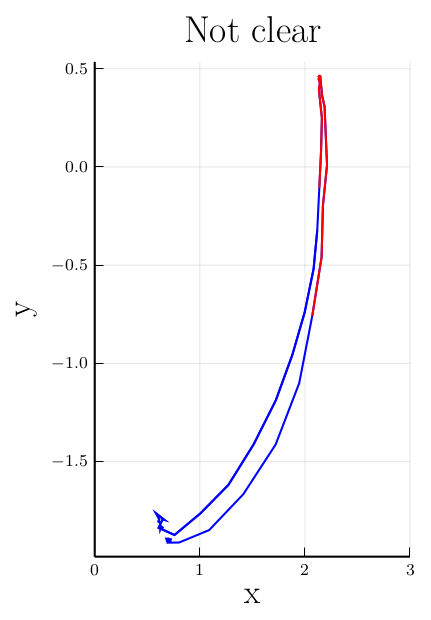

In [ ]:
NCC_plot = plot(NCC[1,4], NCC[1,5],
    label = "", linecolor = :blue, linewidth = 1,
    xlims=(0,3), titlefont=font(18, "Arial"), guidefontsize=16, size = (300, 400),
    # legend = :topleft
);

# actually this is not correct, as y axis should indicate a position...
# plot!(NCC[1,4], -NCC[1,25],
#     label = "Thumb orientation", linecolor = :red, linewidth = 1,)

# it is better to give the same idea but coloring the main signal in red, when the thumb 
# is down
x = NCC[1,4]; y = NCC[1,5];
x2 = x[15:32]; y2 = y[15:32];
x3 = x[33:end]; y3 = y[33:end];

plot!(x2, y2, linecolor = :red, linewidth = 1, label = "")  # red segment
plot!(x3, y3, linecolor = :blue, linewidth = 1, label = "")  # after red


xlabel!("x")
ylabel!("y")

# title!("Not clear")

savefig("results/plot_NCC.tex");

In [125]:
LWC_plot = plot(LWC[1,1], LWC[1,2],
    label = "", linecolor = :blue, linewidth = 1,
    xlims=(-1,2), titlefont=font(18, "Arial"), guidefontsize=16, size = (300, 400),
    legend = :topleft
);

plot!(LWC[1,4], LWC[1,5],
    label = "", linecolor = :red, linewidth = 1,)

plot!(LWC[1,7], LWC[1,8],
    label = "", linecolor = :violet, linewidth = 1,)

plot!(LWC[1,10], LWC[1,11],
    label = "", linecolor = :orange, linewidth = 1,)

xlabel!("x")
ylabel!("y")
zlabel!("z")

title!("Locked wings")

savefig("results/plot_LWC.tex");